# Análise Exploratória de Dados (EDA) - Dataset de Sepsis

Este notebook realiza uma análise exploratória estruturada do dataset de sepsis, assumindo que os dados de treino e teste já foram divididos e estão disponíveis como:
- `dataset_sepsis_train.csv` 
- `dataset_sepsis_test.csv`

## Estrutura da Análise

1. **Carregamento e Preparação dos Dados**
2. **Detetive de NaNs** - Análise de valores faltantes
3. **Desvendando as Categorias** - Análise de variáveis categóricas
4. **Conectando Categorias e Números** - Análise mista
5. **Análise de Features** - Estatísticas descritivas
6. **Distribuição do Target** - Análise da variável alvo


In [13]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')

# Configuração de plotagem
plt.style.use('default')
sns.set_palette("husl")
plt.rcParams['figure.figsize'] = (12, 8)

print("Bibliotecas importadas com sucesso!")

Bibliotecas importadas com sucesso!


In [14]:
def get_display_names():
    """
    Retorna mapeamento de nomes técnicos para nomes mais descritivos para exibição.
    """
    display_mapping = {
        'Unit1': 'UTI Médica',
        'Unit2': 'UTI Cirúrgica', 
        'Gender': 'Gênero',
        'Age': 'Idade',
        'HR': 'Freq. Cardíaca',
        'SBP': 'PA Sistólica',
        'DBP': 'PA Diastólica',
        'MAP': 'PA Média',
        'Temp': 'Temperatura',
        'Resp': 'Freq. Respiratória',
        'O2Sat': 'Saturação O2',
        'HospAdmTime': 'Tempo Internação',
        'ICULOS': 'Tempo UTI'
    }
    return display_mapping

def apply_display_names(df, columns_to_map=None):
    """
    Aplica nomes mais descritivos às colunas para exibição (não altera dados originais).
    """
    display_mapping = get_display_names()
    df_display = df.copy()
    
    if columns_to_map is None:
        columns_to_map = df_display.columns
    
    # Renomeia apenas as colunas que têm mapeamento
    rename_dict = {col: display_mapping.get(col, col) for col in columns_to_map if col in display_mapping}
    df_display = df_display.rename(columns=rename_dict)
    
    return df_display, rename_dict

In [15]:
def get_variable_descriptions():
    """
    Retorna descrições detalhadas das variáveis do dataset PhysioNet 2019 Challenge.
    """
    descriptions = {
        # Identificadores e tempo
        'Hour': 'Hora desde a admissão na UTI (0-335+ horas)',
        'ICULOS': 'Duração da estadia na UTI em horas',
        
        # Sinais vitais
        'HR': 'Frequência cardíaca (batimentos por minuto)',
        'O2Sat': 'Saturação de oxigênio periférico (%)',
        'Temp': 'Temperatura corporal (°C)',
        'SBP': 'Pressão arterial sistólica (mmHg)',
        'MAP': 'Pressão arterial média (mmHg)',
        'DBP': 'Pressão arterial diastólica (mmHg)',
        'Resp': 'Taxa respiratória (respirações por minuto)',
        
        # Gases sanguíneos
        'EtCO2': 'CO2 expirado (mmHg)',
        'BaseExcess': 'Excesso de base (mmol/L)',
        'HCO3': 'Bicarbonato (mmol/L)',
        'FiO2': 'Fração inspirada de oxigênio (0.0-1.0)',
        'pH': 'pH arterial',
        'PaCO2': 'Pressão parcial de CO2 arterial (mmHg)',
        'SaO2': 'Saturação de oxigênio arterial (%)',
        
        # Exames laboratoriais
        'AST': 'Aspartato aminotransferase (IU/L)',
        'BUN': 'Ureia (mg/dL)',
        'Alkalinephos': 'Fosfatase alcalina (IU/L)',
        'Calcium': 'Cálcio (mg/dL)',
        'Chloride': 'Cloreto (mmol/L)',
        'Creatinine': 'Creatinina (mg/dL)',
        'Bilirubin_direct': 'Bilirrubina direta (mg/dL)',
        'Glucose': 'Glicose (mg/dL)',
        'Lactate': 'Lactato (mmol/L)',
        'Magnesium': 'Magnésio (mmol/L)',
        'Phosphate': 'Fosfato (mg/dL)',
        'Potassium': 'Potássio (mmol/L)',
        'Bilirubin_total': 'Bilirrubina total (mg/dL)',
        'TroponinI': 'Troponina I (ng/mL)',
        
        # Hematologia
        'Hct': 'Hematócrito (%)',
        'Hgb': 'Hemoglobina (g/dL)',
        'PTT': 'Tempo de tromboplastina parcial (segundos)',
        'WBC': 'Contagem de glóbulos brancos (1000/uL)',
        'Fibrinogen': 'Fibrinogênio (mg/dL)',
        'Platelets': 'Contagem de plaquetas (1000/uL)',
        
        # Informações demográficas e administrativas
        'Age': 'Idade do paciente (anos)',
        'Gender': 'Gênero do paciente (0=Feminino, 1=Masculino)',
        'Unit1': 'Tipo de UTI - Unidade Médica (0=Não, 1=Sim)',
        'Unit2': 'Tipo de UTI - Unidade Cirúrgica/Cardiológica (0=Não, 1=Sim)',
        'HospAdmTime': 'Tempo entre admissão hospitalar e UTI (horas, valores negativos = admissão direta)',
        
        # Variável alvo
        'SepsisLabel': 'Rótulo de sepsis (0=Não-Sepsis, 1=Sepsis)'
    }
    
    return descriptions

In [16]:
def explain_variable(variable_name):
    """
    Explica uma variável específica do dataset.
    """
    descriptions = get_variable_descriptions()
    
    if variable_name in descriptions:
        print(f"\n=== EXPLICAÇÃO DA VARIÁVEL: {variable_name} ===")
        print(f"Descrição: {descriptions[variable_name]}")
        
        # Informações adicionais específicas por tipo
        if variable_name in ['Unit1', 'Unit2']:
            print(f"\nInformações adicionais:")
            print("• São variáveis binárias mutuamente exclusivas")
            print("• Representam o tipo de UTI onde o paciente está internado")
            print("• Unit1: UTI Médica (pacientes clínicos)")
            print("• Unit2: UTI Cirúrgica/Cardiológica (pacientes cirúrgicos)")
            
        elif variable_name == 'Gender':
            print(f"\nCodificação:")
            print("• 0 = Feminino")
            print("• 1 = Masculino")
            
        elif variable_name == 'SepsisLabel':
            print(f"\nVariável alvo do modelo:")
            print("• 0 = Paciente sem sepse")
            print("• 1 = Paciente com sepse")
            print("• Dataset altamente desbalanceado (~98.2% vs 1.8%)")
            
    else:
        print(f"\nVariável '{variable_name}' não encontrada.")
        print("Variáveis disponíveis:")
        for var in sorted(descriptions.keys()):
            print(f"  • {var}")

def explain_units(X_train):
    """
    Explica especificamente as variáveis Unit1 e Unit2 com análise detalhada.
    """
    print("\n=== EXPLICAÇÃO DAS VARIÁVEIS UNIT1 E UNIT2 ===")
    
    descriptions = get_variable_descriptions()
    
    print("DESCRIÇÃO DAS VARIÁVEIS:")
    print(f"• Unit1: {descriptions['Unit1']}")
    print(f"• Unit2: {descriptions['Unit2']}")
    
    print(f"\nCARACTERÍSTICAS IMPORTANTES:")
    print("• Unit1 e Unit2 são variáveis binárias mutuamente exclusivas")
    print("• Cada paciente está em exatamente um tipo de UTI")
    print("• Unit1 + Unit2 = 1 para todos os pacientes")
    print("• Representam diferentes ambientes clínicos com protocolos distintos")
    
    # Análise da distribuição
    print(f"\nANÁLISE DA DISTRIBUIÇÃO:")
    unit1_count = X_train['Unit1'].value_counts()
    unit2_count = X_train['Unit2'].value_counts()
    
    print(f"Unit1 (UTI Médica):")
    print(f"  • Não (0): {unit1_count[0]:,} pacientes ({unit1_count[0]/len(X_train)*100:.1f}%)")
    print(f"  • Sim (1): {unit1_count[1]:,} pacientes ({unit1_count[1]/len(X_train)*100:.1f}%)")
    
    print(f"\nUnit2 (UTI Cirúrgica/Cardiológica):")
    print(f"  • Não (0): {unit2_count[0]:,} pacientes ({unit2_count[0]/len(X_train)*100:.1f}%)")
    print(f"  • Sim (1): {unit2_count[1]:,} pacientes ({unit2_count[1]/len(X_train)*100:.1f}%)")
    
    # Verificação de complementaridade
    total_check = (X_train['Unit1'] + X_train['Unit2']).unique()
    print(f"\nVERIFICAÇÃO DE COMPLEMENTARIDADE:")
    print(f"• Soma Unit1 + Unit2 = {total_check} (deve ser sempre 1.0)")
    
    print(f"\nIMPLICAÇÕES CLÍNICAS:")
    print("• UTI Médica: Pacientes com condições médicas (pneumonia, sepse, etc.)")
    print("• UTI Cirúrgica/Cardiológica: Pacientes pós-operatórios ou com problemas cardíacos")
    print("• Diferentes perfis de risco e protocolos de tratamento")
    print("• Pode influenciar na apresentação e evolução da sepse")


In [17]:
def load_and_prepare_data():
    """Carrega e prepara os dados para análise (assumindo divisão já feita)."""
    print("Carregando dataset de treino...")
    train_df = pd.read_csv('dataset_sepsis_train.csv')
    
    # Separar X e y para análise
    X_train = train_df.drop('SepsisLabel', axis=1)
    y_train = train_df['SepsisLabel']
    
    print(f"Dados carregados - X_train: {X_train.shape}, y_train: {y_train.shape}")
    print(f"Distribuição target: {y_train.value_counts().to_dict()}")
    
    # Explicar as variáveis Unit1 e Unit2
    explain_units(X_train)
    
    return X_train, y_train

# Carregar os dados
X_train, y_train = load_and_prepare_data()

Carregando dataset de treino...
Dados carregados - X_train: (1241768, 41), y_train: (1241768,)
Distribuição target: {0.0: 1219435, 1.0: 22333}

=== EXPLICAÇÃO DAS VARIÁVEIS UNIT1 E UNIT2 ===
DESCRIÇÃO DAS VARIÁVEIS:
• Unit1: Tipo de UTI - Unidade Médica (0=Não, 1=Sim)
• Unit2: Tipo de UTI - Unidade Cirúrgica/Cardiológica (0=Não, 1=Sim)

CARACTERÍSTICAS IMPORTANTES:
• Unit1 e Unit2 são variáveis binárias mutuamente exclusivas
• Cada paciente está em exatamente um tipo de UTI
• Unit1 + Unit2 = 1 para todos os pacientes
• Representam diferentes ambientes clínicos com protocolos distintos

ANÁLISE DA DISTRIBUIÇÃO:
Unit1 (UTI Médica):
  • Não (0): 378,585 pacientes (30.5%)
  • Sim (1): 373,202 pacientes (30.1%)

Unit2 (UTI Cirúrgica/Cardiológica):
  • Não (0): 373,202 pacientes (30.1%)
  • Sim (1): 378,585 pacientes (30.5%)

VERIFICAÇÃO DE COMPLEMENTARIDADE:
• Soma Unit1 + Unit2 = [ 1. nan] (deve ser sempre 1.0)

IMPLICAÇÕES CLÍNICAS:
• UTI Médica: Pacientes com condições médicas (pneumonia


=== O DETETIVE DE NANS ===
Análise quantitativa dos NaNs:

Resumo dos NaNs:
   Total de colunas: 41
   Colunas com NaNs: 37
   Colunas sem NaNs: 4

Top 10 colunas com mais NaNs:
          Coluna  Valores_Faltantes  Porcentagem
Bilirubin_direct            1239375    99.807291
      Fibrinogen            1233565    99.339410
       TroponinI            1230025    99.054332
 Bilirubin_total            1223250    98.508739
    Alkalinephos            1221814    98.393098
             AST            1221624    98.377797
         Lactate            1208530    97.323333
             PTT            1205078    97.045342
            SaO2            1198991    96.555154
           EtCO2            1195721    96.291819

Gerando heatmap dos NaNs...


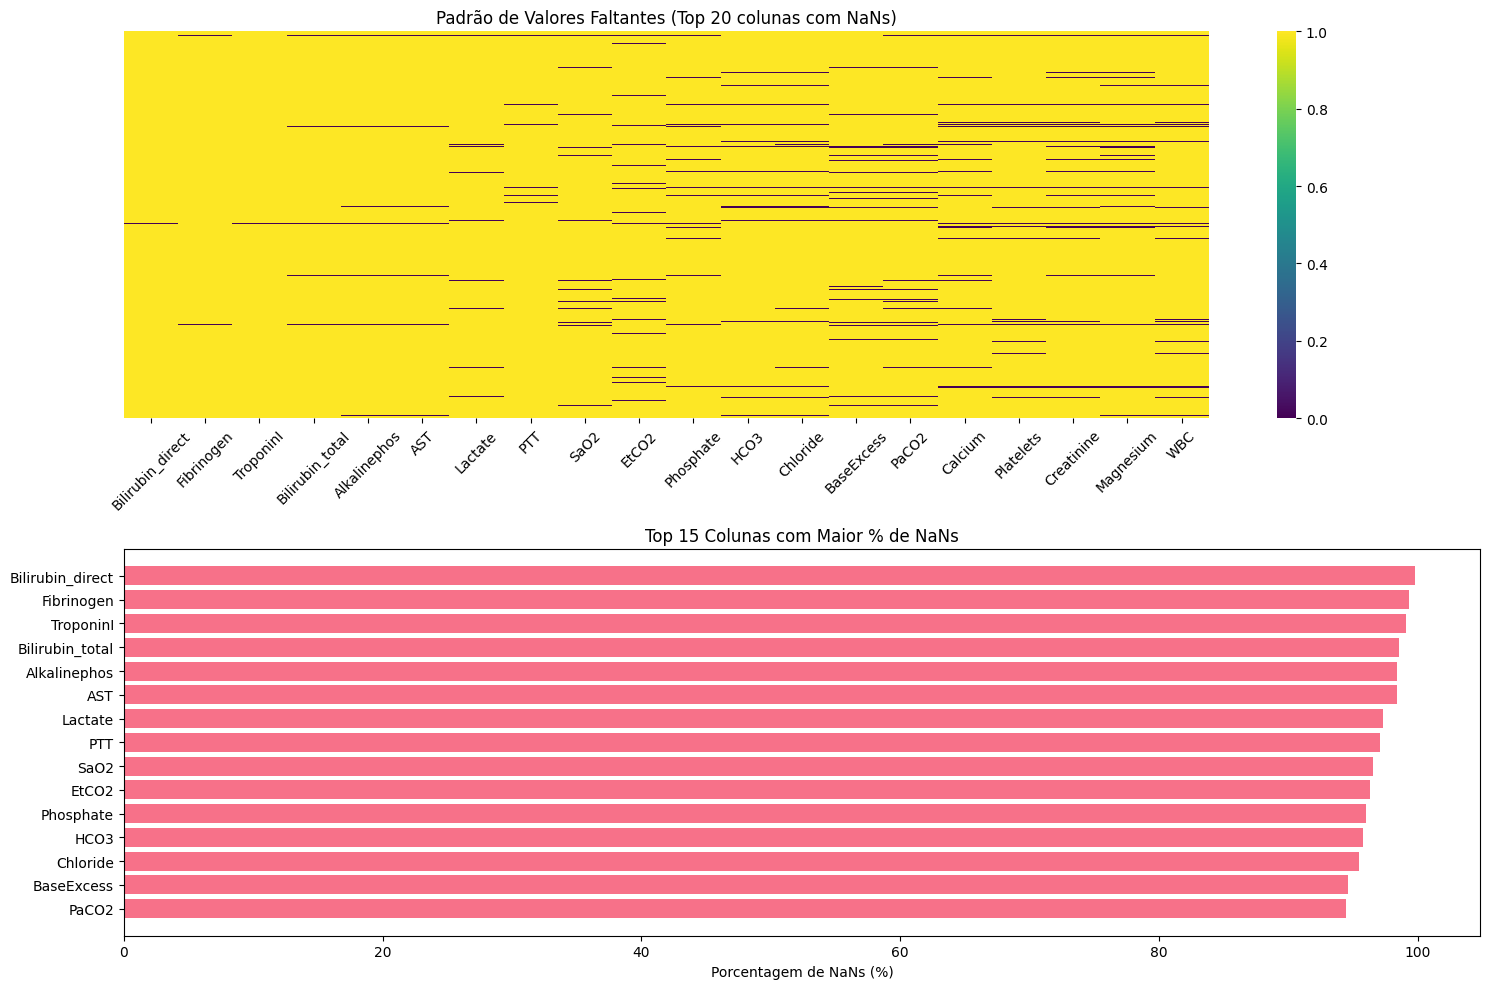


=== ANOTAÇÕES DOS NANs ===
Quais colunas têm NaNs?
   As 37 colunas com NaNs são:
   • Bilirubin_direct: 99.8%
   • Fibrinogen: 99.3%
   • TroponinI: 99.1%
   • Bilirubin_total: 98.5%
   • Alkalinephos: 98.4%
   • AST: 98.4%
   • Lactate: 97.3%
   • PTT: 97.0%
   • SaO2: 96.6%
   • EtCO2: 96.3%

Qual a quantidade?
   • Total de valores faltantes: 34,807,628
   • % do dataset: 68.37%

Há algum padrão?
   • Muito missing (>80%): 27 colunas
   • Médio missing (20-80%): 4 colunas
   • Baixo missing (<20%): 6 colunas

Primeira ideia de tratamento:
   • Colunas >80% NaN: Considerar remoção
   • Colunas 20-80% NaN: Imputação específica por tipo
   • Colunas <20% NaN: Imputação simples (mediana/moda)


In [18]:
def detetive_nans(X_train):
    """
    Analisar e quantificar os NaNs, visualizar padrões e anotar observações.
    """
    print("\n=== O DETETIVE DE NANS ===")
    
    # Analisar e quantificar os NaNs
    print("Análise quantitativa dos NaNs:")
    missing_count = X_train.isnull().sum()
    missing_pct = (missing_count / len(X_train)) * 100
    
    # Cria DataFrame para análise
    missing_df = pd.DataFrame({
        'Coluna': missing_count.index,
        'Valores_Faltantes': missing_count.values,
        'Porcentagem': missing_pct.values
    }).sort_values('Porcentagem', ascending=False)
    
    # Remove colunas sem NaNs para o relatório
    missing_with_nans = missing_df[missing_df['Valores_Faltantes'] > 0]
    
    print(f"\nResumo dos NaNs:")
    print(f"   Total de colunas: {len(X_train.columns)}")
    print(f"   Colunas com NaNs: {len(missing_with_nans)}")
    print(f"   Colunas sem NaNs: {len(X_train.columns) - len(missing_with_nans)}")
    
    print(f"\nTop 10 colunas com mais NaNs:")
    print(missing_with_nans.head(10).to_string(index=False))
    
    # Visualizar os NaNs com heatmap
    print(f"\nGerando heatmap dos NaNs...")
    plt.figure(figsize=(15, 10))
    
    # Seleciona subset de colunas para visualização
    cols_with_nans = missing_with_nans.head(20)['Coluna'].tolist()
    
    if len(cols_with_nans) > 0:
        plt.subplot(2, 1, 1)
        sns.heatmap(X_train[cols_with_nans].isnull(), 
                   cbar=True, 
                   yticklabels=False,
                   cmap='viridis')
        plt.title('Padrão de Valores Faltantes (Top 20 colunas com NaNs)')
        plt.xticks(rotation=45)
        
        # Gráfico de barras com percentuais
        plt.subplot(2, 1, 2)
        top_missing = missing_with_nans.head(15)
        plt.barh(range(len(top_missing)), top_missing['Porcentagem'])
        plt.yticks(range(len(top_missing)), top_missing['Coluna'])
        plt.xlabel('Porcentagem de NaNs (%)')
        plt.title('Top 15 Colunas com Maior % de NaNs')
        plt.gca().invert_yaxis()
        
        plt.tight_layout()
        plt.savefig('nans_analysis.png', dpi=300, bbox_inches='tight')
        plt.show()
    else:
        print("   Nenhum NaN encontrado no dataset!")
    
    # Anotações
    print(f"\n=== ANOTAÇÕES DOS NANs ===")
    print(f"Quais colunas têm NaNs?")
    if len(missing_with_nans) > 0:
        print(f"   As {len(missing_with_nans)} colunas com NaNs são:")
        for _, row in missing_with_nans.head(10).iterrows():
            print(f"   • {row['Coluna']}: {row['Porcentagem']:.1f}%")
    
    print(f"\nQual a quantidade?")
    print(f"   • Total de valores faltantes: {missing_count.sum():,}")
    print(f"   • % do dataset: {(missing_count.sum() / (len(X_train) * len(X_train.columns)))*100:.2f}%")
    
    print(f"\nHá algum padrão?")
    if len(missing_with_nans) > 0:
        high_missing = missing_with_nans[missing_with_nans['Porcentagem'] > 80]
        medium_missing = missing_with_nans[(missing_with_nans['Porcentagem'] > 20) & (missing_with_nans['Porcentagem'] <= 80)]
        low_missing = missing_with_nans[missing_with_nans['Porcentagem'] <= 20]
        
        print(f"   • Muito missing (>80%): {len(high_missing)} colunas")
        print(f"   • Médio missing (20-80%): {len(medium_missing)} colunas")  
        print(f"   • Baixo missing (<20%): {len(low_missing)} colunas")
    
    print(f"\nPrimeira ideia de tratamento:")
    if len(missing_with_nans) > 0:
        print(f"   • Colunas >80% NaN: Considerar remoção")
        print(f"   • Colunas 20-80% NaN: Imputação específica por tipo")
        print(f"   • Colunas <20% NaN: Imputação simples (mediana/moda)")
    else:
        print(f"   • Dataset já está limpo, sem necessidade de tratamento!")
    
    return missing_df

# Executar análise de NaNs
missing_analysis = detetive_nans(X_train)


=== DESVENDANDO AS CATEGORIAS ===
Variáveis categóricas identificadas:
   Categóricas explícitas: 0 -> []
   Potencialmente categóricas (≤10 valores únicos): 3
   ['Gender', 'Unit1', 'Unit2']

Variáveis selecionadas para análise: ['Gender', 'Unit1', 'Unit2']


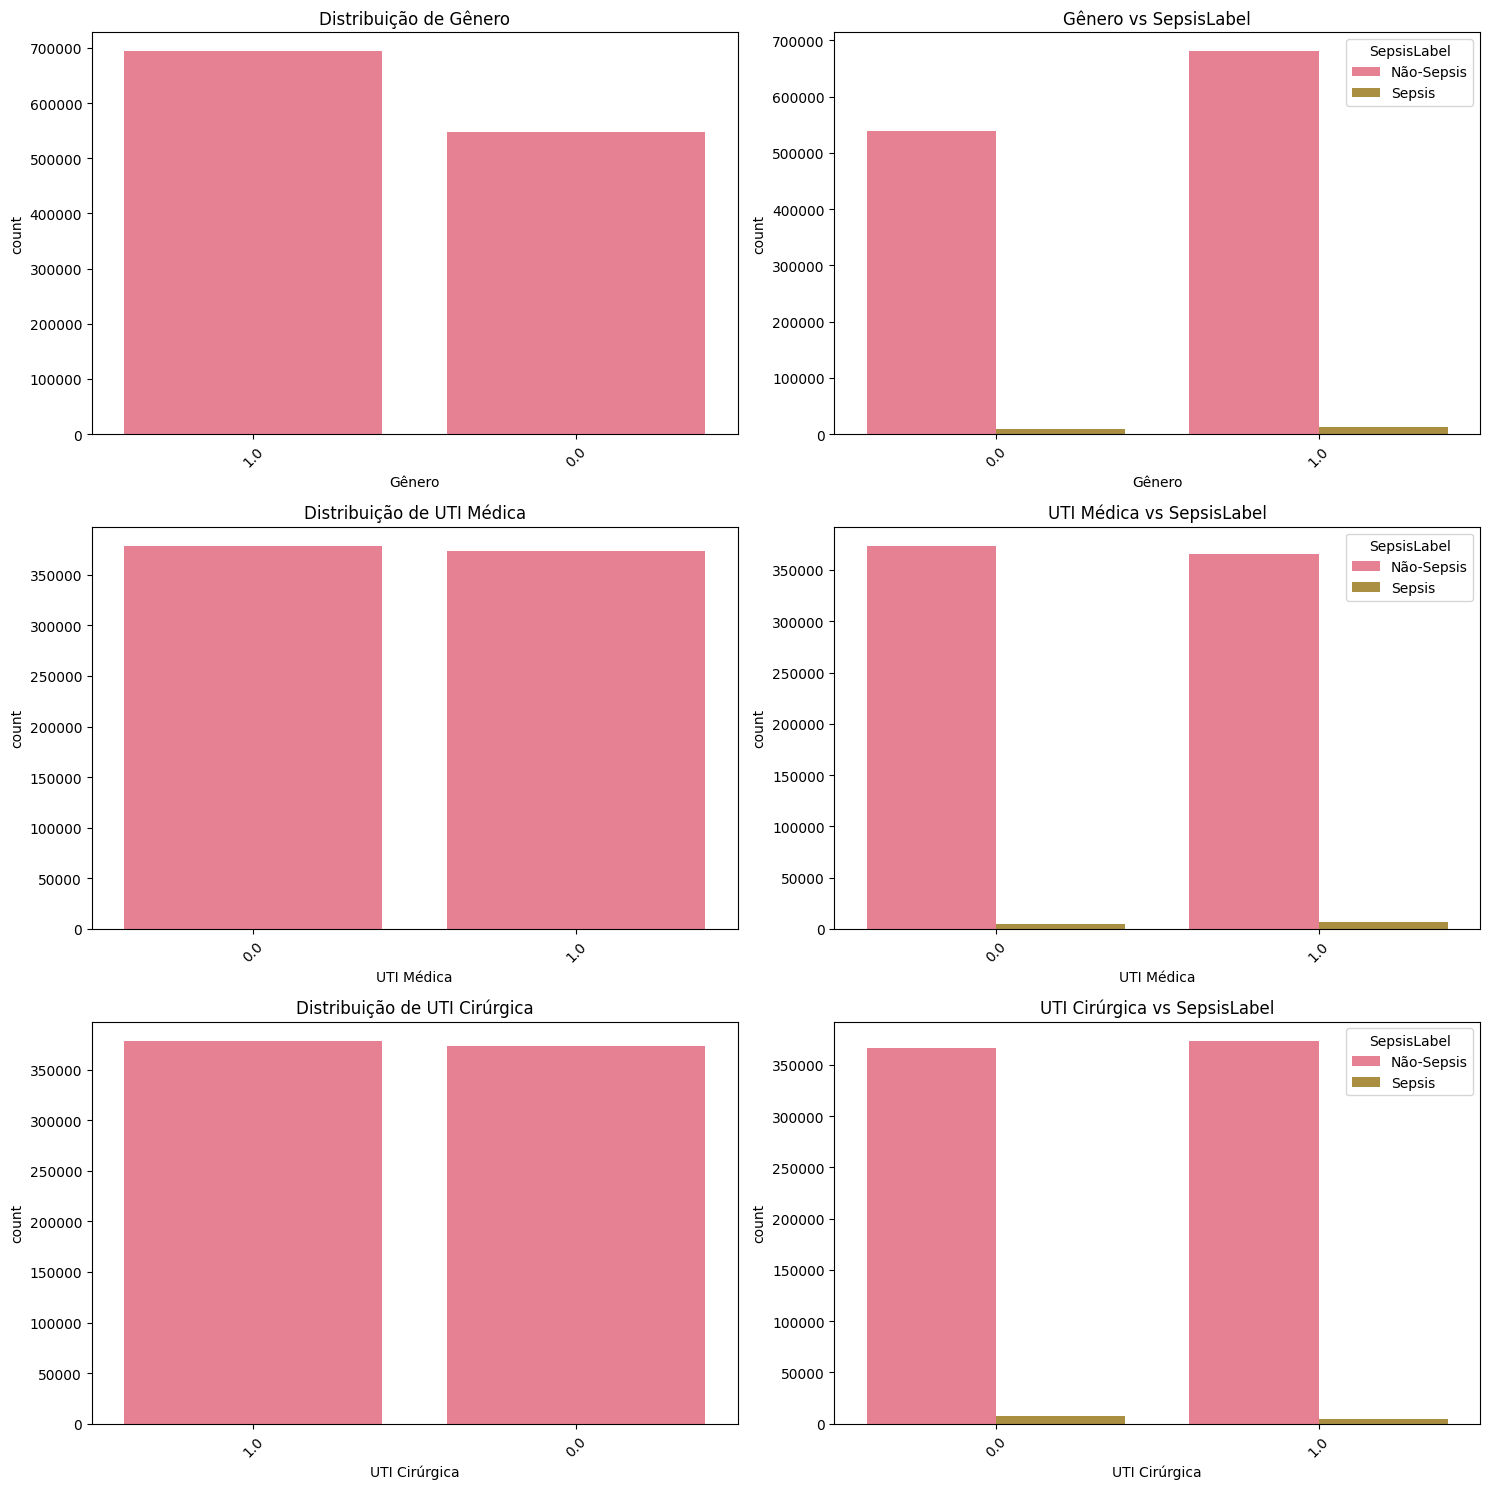


=== ANOTAÇÕES DAS CATEGORIAS ===

Gênero (Gender):
   • Valores únicos: 2
   • Categoria mais frequente: 1.0 (694,449 ocorrências)
   • Categoria com maior risco de sepsis: 1.0 (1.9%)

UTI Médica (Unit1):
   • Valores únicos: 2
   • Categoria mais frequente: 0.0 (378,585 ocorrências)
   • Categoria com maior risco de sepsis: 1.0 (1.9%)

UTI Cirúrgica (Unit2):
   • Valores únicos: 2
   • Categoria mais frequente: 1.0 (378,585 ocorrências)
   • Categoria com maior risco de sepsis: 0.0 (1.9%)


In [19]:
def desvendando_categorias(X_train, y_train):
    """
    Escolher 2-3 variáveis categóricas e criar gráficos simples e vs target.
    """
    print("\n=== DESVENDANDO AS CATEGORIAS ===")
    
    # Identificar variáveis categóricas
    categorical_cols = X_train.select_dtypes(include=['object', 'category']).columns.tolist()
    
    # Para dataset de sepsis, algumas variáveis numéricas são categóricas
    potential_categorical = []
    for col in X_train.columns:
        if X_train[col].nunique() <= 10 and X_train[col].dtype in ['int64', 'float64']:
            potential_categorical.append(col)
    
    print(f"Variáveis categóricas identificadas:")
    print(f"   Categóricas explícitas: {len(categorical_cols)} -> {categorical_cols}")
    print(f"   Potencialmente categóricas (≤10 valores únicos): {len(potential_categorical)}")
    print(f"   {potential_categorical[:10]}{'...' if len(potential_categorical) > 10 else ''}")
    
    # Escolher 2-3 variáveis categóricas relevantes
    selected_categorical = []
    
    # Priorizar algumas variáveis conhecidas do dataset de sepsis
    important_categorical = ['Gender', 'Unit1', 'Unit2', 'Hour']
    
    for col in important_categorical:
        if col in X_train.columns and X_train[col].nunique() <= 20:
            selected_categorical.append(col)
        if len(selected_categorical) >= 3:
            break
    
    # Se não encontrou suficientes, pega das potencialmente categóricas
    if len(selected_categorical) < 3:
        for col in potential_categorical:
            if col not in selected_categorical:
                selected_categorical.append(col)
            if len(selected_categorical) >= 3:
                break
    
    print(f"\nVariáveis selecionadas para análise: {selected_categorical}")
    
    # Criar gráficos categóricos com nomes descritivos
    fig, axes = plt.subplots(len(selected_categorical), 2, figsize=(15, 5*len(selected_categorical)))
    if len(selected_categorical) == 1:
        axes = axes.reshape(1, -1)
    
    # Obter mapeamento de nomes para exibição
    display_mapping = get_display_names()
    
    for i, col in enumerate(selected_categorical):
        # Nome para exibição
        display_name = display_mapping.get(col, col)
        
        # Gráfico simples de contagem
        plt.subplot(len(selected_categorical), 2, 2*i + 1)
        counts = X_train[col].value_counts().head(10)
        sns.countplot(data=X_train, x=col, order=counts.index)
        plt.title(f'Distribuição de {display_name}')
        plt.xlabel(display_name)
        plt.xticks(rotation=45)
        
        # Gráfico Categoria vs. Variável Alvo
        plt.subplot(len(selected_categorical), 2, 2*i + 2)
        temp_df = pd.DataFrame({'cat': X_train[col], 'target': y_train})
        top_categories = X_train[col].value_counts().head(10).index
        temp_df_filtered = temp_df[temp_df['cat'].isin(top_categories)]
        
        sns.countplot(data=temp_df_filtered, x='cat', hue='target')
        plt.title(f'{display_name} vs SepsisLabel')
        plt.xlabel(display_name)
        plt.xticks(rotation=45)
        plt.legend(title='SepsisLabel', labels=['Não-Sepsis', 'Sepsis'])
    
    plt.tight_layout()
    plt.savefig('categorical_analysis.png', dpi=300, bbox_inches='tight')
    plt.show()
    
    # Anotações
    print(f"\n=== ANOTAÇÕES DAS CATEGORIAS ===")
    display_mapping = get_display_names()
    
    for col in selected_categorical:
        display_name = display_mapping.get(col, col)
        print(f"\n{display_name} ({col}):")
        value_counts = X_train[col].value_counts()
        print(f"   • Valores únicos: {X_train[col].nunique()}")
        print(f"   • Categoria mais frequente: {value_counts.index[0]} ({value_counts.iloc[0]:,} ocorrências)")
        
        # Relação com target
        crosstab = pd.crosstab(X_train[col], y_train, normalize='index')
        if len(crosstab) > 0:
            # Encontra categoria com maior proporção de sepsis
            max_sepsis_cat = crosstab[1.0].idxmax() if 1.0 in crosstab.columns else "N/A"
            max_sepsis_pct = crosstab[1.0].max() if 1.0 in crosstab.columns else 0
            print(f"   • Categoria com maior risco de sepsis: {max_sepsis_cat} ({max_sepsis_pct:.1%})")
    
    return selected_categorical

# Executar análise categórica
categorical_vars = desvendando_categorias(X_train, y_train)


=== CONECTANDO CATEGORIAS E NÚMEROS ===
Variáveis numéricas disponíveis: 13
Variáveis numéricas selecionadas: ['HR', 'SBP', 'DBP']
Variáveis categóricas disponíveis: ['Gender', 'Unit1', 'Unit2']


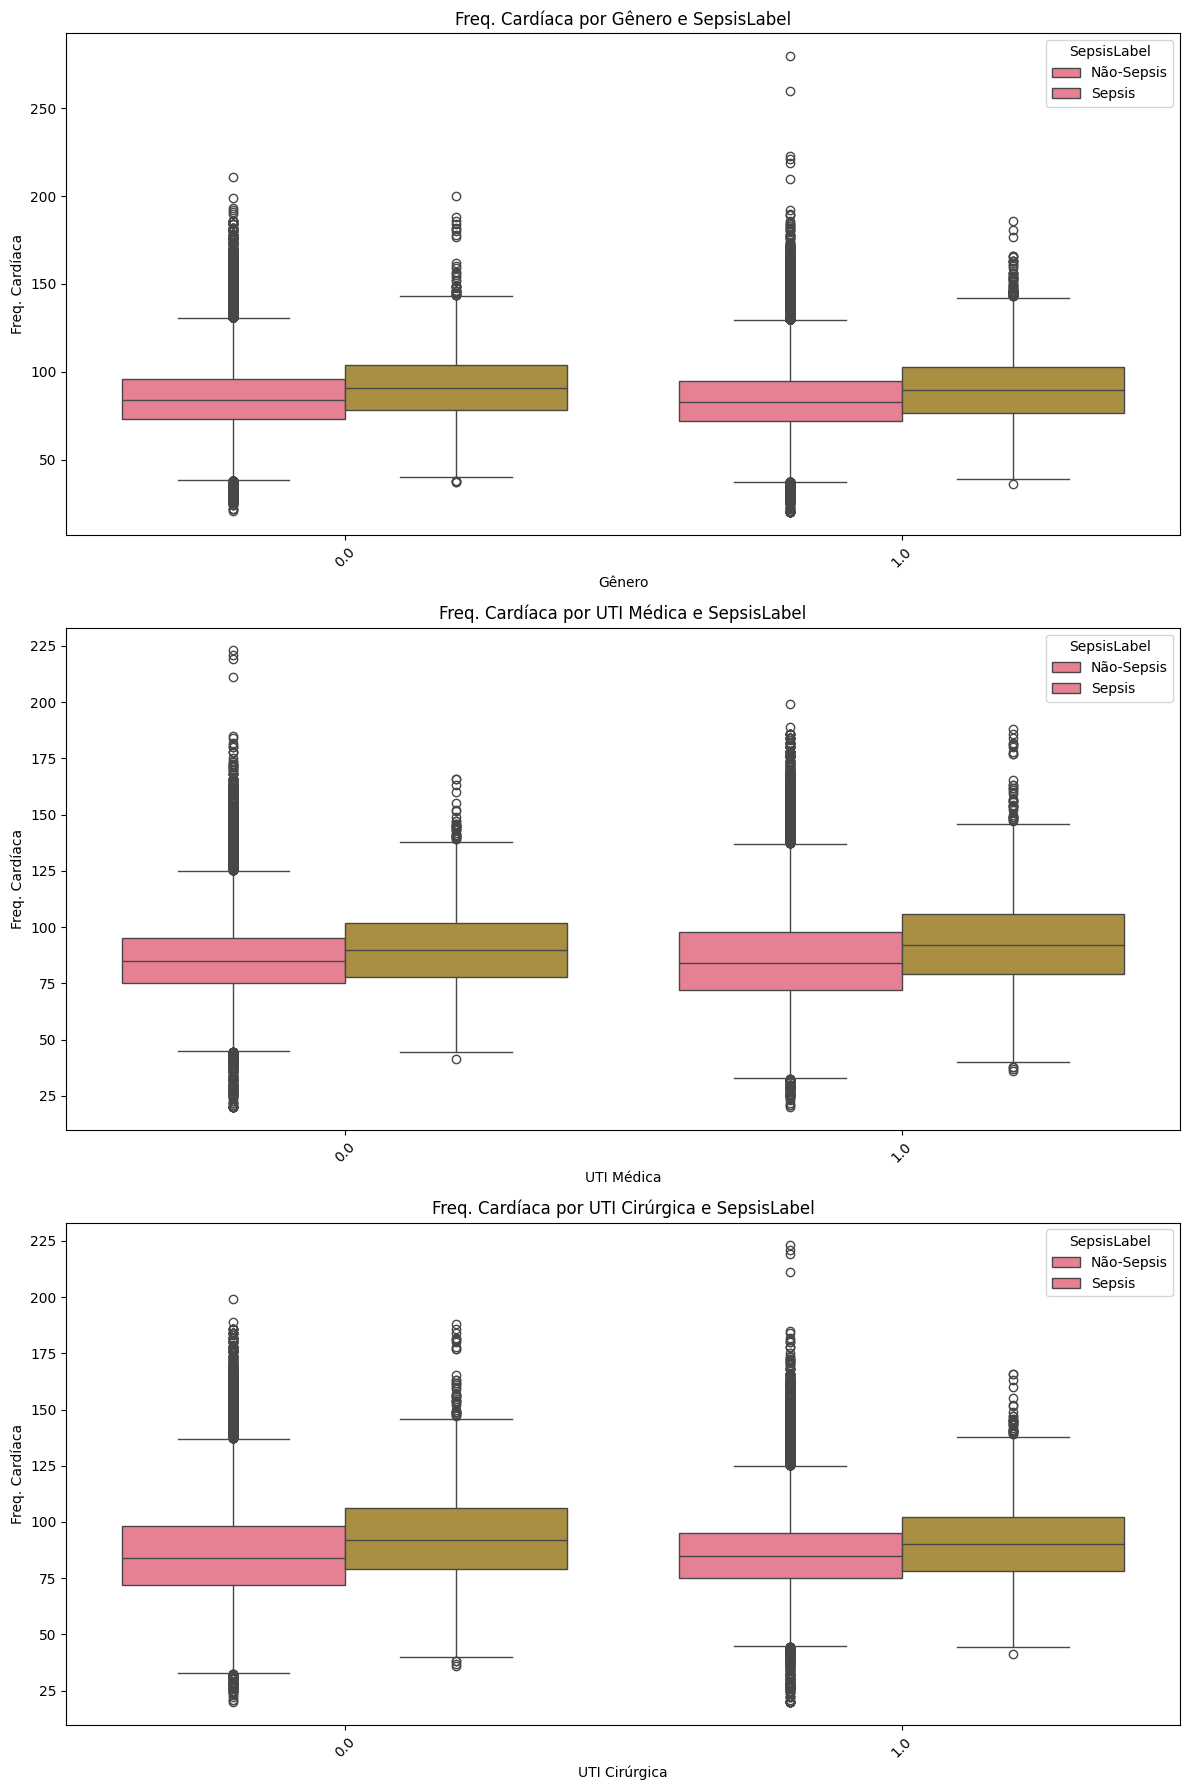


=== ANOTAÇÕES CATEGORIAS vs NÚMEROS ===

Freq. Cardíaca por Gênero:
   • Como a distribuição varia entre categorias:
     - Maior média: 0.0 (85.18)
     - Menor média: 1.0 (84.11)
     - Maior variabilidade: 0.0 (std: 17.47)
   • Outliers significativos:
     - 1.0: 6537 outliers
     - 0.0: 5596 outliers

Freq. Cardíaca por UTI Médica:
   • Como a distribuição varia entre categorias:
     - Maior média: 1.0 (85.80)
     - Menor média: 0.0 (85.66)
     - Maior variabilidade: 1.0 (std: 18.42)
   • Outliers significativos:
     - 0.0: 5047 outliers
     - 1.0: 2316 outliers

Freq. Cardíaca por UTI Cirúrgica:
   • Como a distribuição varia entre categorias:
     - Maior média: 0.0 (85.80)
     - Menor média: 1.0 (85.66)
     - Maior variabilidade: 0.0 (std: 18.42)
   • Outliers significativos:
     - 1.0: 5047 outliers
     - 0.0: 2316 outliers


In [20]:
def conectando_categorias_numeros(X_train, y_train, categorical_cols):
    """
    Conectando Categorias e Números
    Escolher uma variável categórica e uma numérica para gráficos mistos.
    """
    print("\n=== CONECTANDO CATEGORIAS E NÚMEROS ===")
    
    # Identificar variáveis numéricas relevantes
    numeric_cols = X_train.select_dtypes(include=[np.number]).columns.tolist()
    
    # Remover colunas com muitos NaNs para análise mais limpa
    numeric_cols_clean = []
    for col in numeric_cols:
        missing_pct = X_train[col].isnull().sum() / len(X_train) * 100
        if missing_pct < 50:  # Menos de 50% de NaNs
            numeric_cols_clean.append(col)
    
    print(f"Variáveis numéricas disponíveis: {len(numeric_cols_clean)}")
    
    # Selecionar variáveis numéricas importantes (sinais vitais)
    important_numeric = ['HR', 'SBP', 'DBP', 'Temp', 'Resp', 'O2Sat', 'Age']
    selected_numeric = []
    
    for col in important_numeric:
        if col in numeric_cols_clean:
            selected_numeric.append(col)
        if len(selected_numeric) >= 3:
            break
    
    # Se não encontrou suficientes, pega outras
    if len(selected_numeric) < 3:
        for col in numeric_cols_clean:
            if col not in selected_numeric:
                selected_numeric.append(col)
            if len(selected_numeric) >= 3:
                break
    
    print(f"Variáveis numéricas selecionadas: {selected_numeric}")
    print(f"Variáveis categóricas disponíveis: {categorical_cols}")
    
    # Criar gráficos mistos para cada combinação
    n_combinations = min(3, len(categorical_cols) * len(selected_numeric))
    fig, axes = plt.subplots(n_combinations, 1, figsize=(12, 6*n_combinations))
    
    if n_combinations == 1:
        axes = [axes]
    
    combination_count = 0
    annotations = []
    
    for cat_col in categorical_cols[:3]:  # Máximo 3 categóricas
        for num_col in selected_numeric[:1]:  # 1 numérica por categórica
            if combination_count >= n_combinations:
                break
                
            plt.subplot(n_combinations, 1, combination_count + 1)
            
            # Preparar dados removendo NaNs
            temp_df = pd.DataFrame({
                'categorical': X_train[cat_col],
                'numerical': X_train[num_col],
                'target': y_train
            }).dropna()
            
            # Filtrar top categorias para visualização limpa
            top_categories = temp_df['categorical'].value_counts().head(8).index
            temp_df_filtered = temp_df[temp_df['categorical'].isin(top_categories)]
            
            if len(temp_df_filtered) > 0:
                # Obter nomes para exibição
                display_mapping = get_display_names()
                cat_display_name = display_mapping.get(cat_col, cat_col)
                num_display_name = display_mapping.get(num_col, num_col)
                
                sns.boxplot(data=temp_df_filtered, x='categorical', y='numerical', hue='target')
                plt.title(f'{num_display_name} por {cat_display_name} e SepsisLabel')
                plt.xlabel(cat_display_name)
                plt.ylabel(num_display_name)
                plt.xticks(rotation=45)
                plt.legend(title='SepsisLabel', labels=['Não-Sepsis', 'Sepsis'])
                
                # Coleta dados para anotações
                stats_by_cat = temp_df_filtered.groupby('categorical')['numerical'].agg(['mean', 'std', 'min', 'max'])
                outliers_info = []
                
                # Detecta outliers usando IQR
                for cat in top_categories:
                    cat_data = temp_df_filtered[temp_df_filtered['categorical'] == cat]['numerical']
                    Q1 = cat_data.quantile(0.25)
                    Q3 = cat_data.quantile(0.75)
                    IQR = Q3 - Q1
                    outliers = cat_data[(cat_data < Q1 - 1.5*IQR) | (cat_data > Q3 + 1.5*IQR)]
                    if len(outliers) > 0:
                        outliers_info.append(f"{cat}: {len(outliers)} outliers")
                
                annotations.append({
                    'categorical': cat_col,
                    'numerical': num_col,
                    'stats': stats_by_cat,
                    'outliers': outliers_info
                })
            
            combination_count += 1
    
    plt.tight_layout()
    plt.savefig('categorical_numerical_analysis.png', dpi=300, bbox_inches='tight')
    plt.show()
    
    # Anotações
    print(f"\n=== ANOTAÇÕES CATEGORIAS vs NÚMEROS ===")
    display_mapping = get_display_names()
    
    for annotation in annotations:
        cat_col = annotation['categorical']
        num_col = annotation['numerical']
        stats = annotation['stats']
        outliers = annotation['outliers']
        
        cat_display_name = display_mapping.get(cat_col, cat_col)
        num_display_name = display_mapping.get(num_col, num_col)
        
        print(f"\n{num_display_name} por {cat_display_name}:")
        print(f"   • Como a distribuição varia entre categorias:")
        
        if len(stats) > 0:
            # Categoria com maior média
            max_mean_cat = stats['mean'].idxmax()
            min_mean_cat = stats['mean'].idxmin()
            print(f"     - Maior média: {max_mean_cat} ({stats.loc[max_mean_cat, 'mean']:.2f})")
            print(f"     - Menor média: {min_mean_cat} ({stats.loc[min_mean_cat, 'mean']:.2f})")
            
            # Categoria com maior variabilidade
            max_std_cat = stats['std'].idxmax()
            print(f"     - Maior variabilidade: {max_std_cat} (std: {stats.loc[max_std_cat, 'std']:.2f})")
        
        print(f"   • Outliers significativos:")
        if outliers:
            for outlier_info in outliers:
                print(f"     - {outlier_info}")
        else:
            print(f"     - Nenhum outlier significativo detectado")
    
    return annotations

# Executar análise mista
mixed_analysis = conectando_categorias_numeros(X_train, y_train, categorical_vars)

In [21]:
def analyze_features(df):
    """Análise básica das features numéricas."""
    print("\n=== ANÁLISE DAS FEATURES ===")
    
    # Features numéricas (excluindo SepsisLabel)
    numeric_features = df.select_dtypes(include=[np.number]).columns.tolist()
    if 'SepsisLabel' in numeric_features:
        numeric_features.remove('SepsisLabel')
    
    print(f"Número de features numéricas: {len(numeric_features)}")
    
    # Informações sobre as features do dataset PhysioNet 2019
    print(f"\nTipos de features no dataset:")
    feature_groups = {
        'Sinais Vitais': ['HR', 'O2Sat', 'Temp', 'SBP', 'MAP', 'DBP', 'Resp'],
        'Gases Sanguíneos': ['EtCO2', 'BaseExcess', 'HCO3', 'FiO2', 'pH', 'PaCO2', 'SaO2'],
        'Exames Laboratoriais': ['AST', 'BUN', 'Alkalinephos', 'Calcium', 'Chloride', 'Creatinine', 
                               'Bilirubin_direct', 'Glucose', 'Lactate', 'Magnesium', 'Phosphate', 
                               'Potassium', 'Bilirubin_total', 'TroponinI'],
        'Hematologia': ['Hct', 'Hgb', 'PTT', 'WBC', 'Fibrinogen', 'Platelets'],
        'Informações Clínicas': ['Age', 'Gender', 'UTI_Medica', 'UTI_Cirurgica', 'HospAdmTime', 'ICULOS', 'Hour']
    }
    
    for group_name, group_features in feature_groups.items():
        available_features = [f for f in group_features if f in df.columns]
        print(f"  {group_name}: {len(available_features)} features disponíveis")
        if available_features:
            print(f"    {available_features[:5]}{'...' if len(available_features) > 5 else ''}")
    
    # Estatísticas descritivas das features de sinais vitais
    vital_signs = [f for f in feature_groups['Sinais Vitais'] if f in df.columns]
    if vital_signs:
        print(f"\nEstatísticas dos Sinais Vitais:")
        print(df[vital_signs].describe().round(2))
    
    return numeric_features

# Combinar X_train e y_train para análise completa
train_df = pd.concat([X_train, y_train], axis=1)
numeric_features = analyze_features(train_df)


=== ANÁLISE DAS FEATURES ===
Número de features numéricas: 41

Tipos de features no dataset:
  Sinais Vitais: 7 features disponíveis
    ['HR', 'O2Sat', 'Temp', 'SBP', 'MAP']...
  Gases Sanguíneos: 7 features disponíveis
    ['EtCO2', 'BaseExcess', 'HCO3', 'FiO2', 'pH']...
  Exames Laboratoriais: 14 features disponíveis
    ['AST', 'BUN', 'Alkalinephos', 'Calcium', 'Chloride']...
  Hematologia: 6 features disponíveis
    ['Hct', 'Hgb', 'PTT', 'WBC', 'Fibrinogen']...
  Informações Clínicas: 5 features disponíveis
    ['Age', 'Gender', 'HospAdmTime', 'ICULOS', 'Hour']

Estatísticas dos Sinais Vitais:
               HR       O2Sat       Temp         SBP         MAP        DBP  \
count  1119123.00  1079708.00  419945.00  1060857.00  1087236.00  852691.00   
mean        84.58       97.19      36.98      123.76       82.40      63.83   
std         17.32        2.93       0.77       23.23       16.34      13.95   
min         20.00       20.00      23.00       20.00       20.00      20.00  

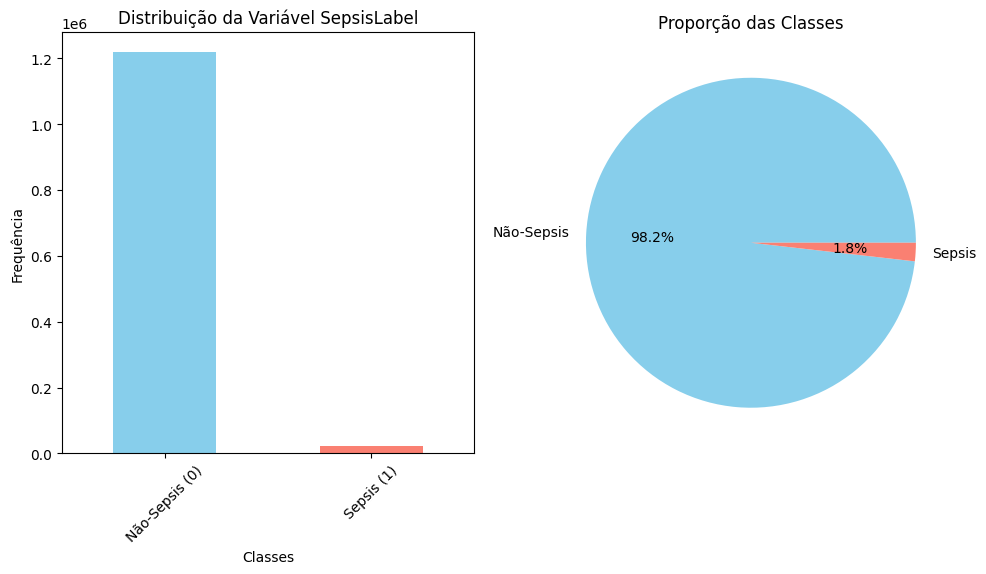


=== ANÁLISE DE DADOS FALTANTES ===

Features com >50% de dados faltantes: 28
Bilirubin_direct    99.807291
Fibrinogen          99.339410
TroponinI           99.054332
Bilirubin_total     98.508739
Alkalinephos        98.393098
dtype: float64

Features com <10% de dados faltantes: 2
HR             9.876644
HospAdmTime    0.000483
dtype: float64

=== ANÁLISE DE FEATURES ESPECÍFICAS ===
Analisando features: ['Hour', 'HR', 'O2Sat', 'SBP', 'MAP']

--- Hour ---
               count       mean        std  min  max
SepsisLabel                                         
0.0          1219435  24.979596  27.786765    0  335
1.0            22333  54.367841  59.132246    0  335

--- HR ---
               count       mean        std   min    max
SepsisLabel                                            
0.0          1098561  84.464360  17.270879  20.0  280.0
1.0            20562  90.735848  18.982641  36.0  200.0

--- O2Sat ---
               count       mean       std   min    max
SepsisLabel          

In [22]:
def plot_target_distribution(df):
    """Visualiza a distribuição da variável target (SepsisLabel)."""
    plt.figure(figsize=(10, 6))
    
    # Gráfico de barras
    target_counts = df['SepsisLabel'].value_counts()
    plt.subplot(1, 2, 1)
    target_counts.plot(kind='bar', color=['skyblue', 'salmon'])
    plt.title('Distribuição da Variável SepsisLabel')
    plt.xlabel('Classes')
    plt.ylabel('Frequência')
    plt.xticks([0, 1], ['Não-Sepsis (0)', 'Sepsis (1)'], rotation=45)
    
    # Gráfico de pizza
    plt.subplot(1, 2, 2)
    target_pct = df['SepsisLabel'].value_counts(normalize=True)
    plt.pie(target_pct.values, labels=['Não-Sepsis', 'Sepsis'], 
            autopct='%1.1f%%', colors=['skyblue', 'salmon'])
    plt.title('Proporção das Classes')
    
    plt.tight_layout()
    plt.savefig('sepsis_target_distribution.png', dpi=300, bbox_inches='tight')
    plt.show()

def analyze_missing_data(df):
    """Análise detalhada dos dados faltantes."""
    print("\n=== ANÁLISE DE DADOS FALTANTES ===")
    
    missing_summary = df.isnull().sum().sort_values(ascending=False)
    missing_pct = (missing_summary / len(df)) * 100
    
    # Features com mais de 50% de dados faltantes
    high_missing = missing_pct[missing_pct > 50]
    print(f"\nFeatures com >50% de dados faltantes: {len(high_missing)}")
    if len(high_missing) > 0:
        print(high_missing.head())
    
    # Features com poucos dados faltantes (< 10%)
    low_missing = missing_pct[(missing_pct > 0) & (missing_pct < 10)]
    print(f"\nFeatures com <10% de dados faltantes: {len(low_missing)}")
    if len(low_missing) > 0:
        print(low_missing.head())

def sample_feature_analysis(df, numeric_features):
    """Análise de algumas features específicas."""
    print("\n=== ANÁLISE DE FEATURES ESPECÍFICAS ===")
    
    # Analisa as primeiras 5 features com menos dados faltantes
    features_to_analyze = []
    for feature in numeric_features:
        missing_pct = (df[feature].isnull().sum() / len(df)) * 100
        if missing_pct < 20:  # Menos de 20% de dados faltantes
            features_to_analyze.append(feature)
        if len(features_to_analyze) >= 5:
            break
    
    if features_to_analyze:
        print(f"Analisando features: {features_to_analyze}")
        
        # Estatísticas por classe
        for feature in features_to_analyze[:3]:  # Primeiras 3
            print(f"\n--- {feature} ---")
            stats_by_class = df.groupby('SepsisLabel')[feature].agg(['count', 'mean', 'std', 'min', 'max'])
            print(stats_by_class)

# Visualizar distribuição do target
plot_target_distribution(train_df)

# Análise adicional de dados faltantes
analyze_missing_data(train_df)

# Análise de features específicas
sample_feature_analysis(train_df, numeric_features)

## Resumo e Conclusões da EDA

### Gráficos Gerados:
- **nans_analysis.png** - Análise de valores faltantes
- **categorical_analysis.png** - Análise de variáveis categóricas
- **categorical_numerical_analysis.png** - Análise mista categórica-numérica
- **sepsis_target_distribution.png** - Distribuição da variável alvo

### Principais Descobertas:

1. **Distribuição do Target**: Dataset altamente desbalanceado com ~98.2% de casos não-sepsis e ~1.8% de casos de sepsis

2. **Valores Faltantes**: Muitas variáveis apresentam valores faltantes significativos, especialmente exames laboratoriais

3. **Variáveis Categóricas**: Unit1 e Unit2 são mutuamente exclusivas, representando tipos diferentes de UTI

4. **Sinais Vitais**: Variáveis como HR, SBP, DBP, Temp, Resp, O2Sat são fundamentais para o diagnóstico

### Próximos Passos:
- Tratamento de valores faltantes
- Feature engineering
- Balanceamento de classes
- Modelagem preditiva

In [23]:
# Resumo final dos resultados
print("=== EDA CONCLUÍDO ===")
print("Gráficos salvos:")
print("   • nans_analysis.png")
print("   • categorical_analysis.png") 
print("   • categorical_numerical_analysis.png")
print("   • sepsis_target_distribution.png")

print(f"\nResumo dos resultados:")
print(f"   • Análise de NaNs: {len(missing_analysis)} colunas analisadas")
print(f"   • Variáveis categóricas: {len(categorical_vars)} variáveis")
print(f"   • Análises mistas: {len(mixed_analysis)} combinações")
print(f"   • Features numéricas: {len(numeric_features)} features")

# Retornar resultados para uso posterior
eda_results = {
    'missing_analysis': missing_analysis,
    'categorical_vars': categorical_vars,
    'mixed_analysis': mixed_analysis,
    'numeric_features': numeric_features,
    'X_train': X_train,
    'y_train': y_train
}

print(f"\nEDA concluído com sucesso! Resultados disponíveis em 'eda_results'")

=== EDA CONCLUÍDO ===
Gráficos salvos:
   • nans_analysis.png
   • categorical_analysis.png
   • categorical_numerical_analysis.png
   • sepsis_target_distribution.png

Resumo dos resultados:
   • Análise de NaNs: 41 colunas analisadas
   • Variáveis categóricas: 3 variáveis
   • Análises mistas: 3 combinações
   • Features numéricas: 41 features

EDA concluído com sucesso! Resultados disponíveis em 'eda_results'
